In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, RidgeCV
from statsmodels.tsa.stattools import adfuller

In [6]:
df = pd.read_csv('grocery_dataset_eda.csv')
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df[(df['date'] >= '2005-01-01') & (df['date'] <= '2025-01-01')]
df = df.reset_index().set_index('date').drop(columns = 'index')
df

,US Grocery Sales,CPI (Food at Home),Real Disposable Income,Unemployment Rate,Initial Jobless Claims,Continued Jobless Claims,GDP,Personal Savings,Consumer Debt % DI,Credit Card Delinquency,...,Retail Wages_yoy_lag3,Retail Wages_yoy_lag4,Retail Wages_yoy_lag5,Retail Wages_yoy_lag6,Retail Wages_yoy_lag7,Retail Wages_yoy_lag8,Retail Wages_yoy_lag9,Retail Wages_yoy_lag10,Retail Wages_yoy_lag11,Retail Wages_yoy_lag12
date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,37628.0,188.100,11226.5,5.3,1717000.0,13619000.0,15844.727,247.1,7.303833,3.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-01,37553.0,187.700,11229.0,5.4,1247000.0,10746000.0,15844.727,210.6,7.303833,3.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-01,37645.0,188.100,11268.8,5.2,1328000.0,10638000.0,15844.727,230.2,7.303833,3.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-01,38049.0,190.000,11304.2,5.2,1616000.0,13022000.0,15922.782,195.4,7.239296,3.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-05-01,37908.0,190.200,11352.7,5.1,1308000.0,10345000.0,15922.782,243.6,7.239296,3.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01,75140.0,307.201,17519.6,4.1,897000.0,7325000.0,23400.294,830.7,5.478743,3.20,...,2.260360,2.732240,2.099076,2.743774,2.524190,2.931181,3.371746,2.425532,3.178694,4.197317
2024-10-01,75403.0,307.798,17584.7,4.1,948000.0,7494000.0,23536.293,881.0,5.512139,3.08,...,2.130326,2.260360,2.732240,2.099076,2.743774,2.524190,2.931181,3.371746,2.425532,3.178694
2024-11-01,75235.0,308.881,17618.8,4.2,1095000.0,9417000.0,NaN,838.1,NaN,NaN,...,2.292622,2.130326,2.260360,2.732240,2.099076,2.743774,2.524190,2.931181,3.371746,2.425532


In [7]:
# Count total missing values per column
missing_counts = df.isna().sum()
missing_counts = missing_counts[missing_counts > 0]
missing_counts

Initial Jobless Claims       1
Continued Jobless Claims     1
GDP                          3
Consumer Debt % DI           3
Credit Card Delinquency      3
                            ..
Retail Wages_yoy_lag8       34
Retail Wages_yoy_lag9       35
Retail Wages_yoy_lag10      36
Retail Wages_yoy_lag11      37
Retail Wages_yoy_lag12      38
Length: 254, dtype: int64

In [8]:
# Count infs
inf_counts = df.isin([np.inf, -np.inf]).sum()
inf_counts = inf_counts[inf_counts>0]
inf_counts

Series([], dtype: int64)

In [9]:
for col in df.columns:
    print(col)

US Grocery Sales
CPI (Food at Home)
Real Disposable Income
Unemployment Rate
Initial Jobless Claims
Continued Jobless Claims
GDP
Personal Savings
Consumer Debt % DI
Credit Card Delinquency
Mortgage Delinquency
Oil Prices
Avg Home Price
Consumer Sentiment
PPI Final Food
PPI Food and Feed
PPI Finished Consumer Goods
PPI Food Manufacture
PPI Grocery
Retail Wages
us_grocery_units
Real Disposable Income adj
US Grocery Sales_lag1
covid1
covid2
US Grocery Sales_diff
CPI (Food at Home)_diff
Real Disposable Income_diff
Unemployment Rate_diff
Initial Jobless Claims_diff
Continued Jobless Claims_diff
GDP_diff
Personal Savings_diff
Consumer Debt % DI_diff
Credit Card Delinquency_diff
Mortgage Delinquency_diff
Oil Prices_diff
Avg Home Price_diff
Consumer Sentiment_diff
PPI Final Food_diff
PPI Food and Feed_diff
PPI Finished Consumer Goods_diff
PPI Food Manufacture_diff
PPI Grocery_diff
Retail Wages_diff
us_grocery_units_diff
Real Disposable Income adj_diff
US Grocery Sales_lag1_diff
US Grocery Sale

### RIDGE ###


In [10]:
# Define Features (X) and Target (y)
X = df[['US Grocery Sales_lag1', 'CPI (Food at Home)', 'Avg Home Price', 'Real Disposable Income adj', 'Credit Card Delinquency', 'covid1', 'covid2']]
y = df['US Grocery Sales'] 

# Handle missing values (fill with median)
X = X.fillna(X.median())

# Standardize features (important for Ridge Regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Standardize the features

# Convert back to a DataFrame to retain column names
X_scaled_df = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

# Define training data (2004-2023) and test data (2024)
X_train = X_scaled_df.loc[:'2023-12-31']  # Features for 2004-2023
y_train = y.loc[:'2023-12-31']            # Target for 2004-2023

X_test = X_scaled_df.loc['2024-01-01':]   # Features for 2024
y_test = y.loc['2024-01-01':]             # Target for 2024

# Print train/test sizes to verify
print(f"Train Size: {X_train.shape}, Test Size: {X_test.shape}")


Train Size: (228, 7), Test Size: (13, 7)


In [11]:
# Define a range of alpha values to test
alpha_values = np.logspace(-3, 3, 100)  # Values from 0.001 to 1000

# Ridge Regression with cross-validation
ridge_cv = RidgeCV(alphas=alpha_values, store_cv_results=True)
ridge_cv.fit(X_train, y_train)

# Best alpha value selected
best_alpha = ridge_cv.alpha_
print(f"🔍 Best Alpha Found: {best_alpha}")

# Train Ridge model with best alpha
ridge = Ridge(alpha=3.7649)  # Directly using best value
ridge.fit(X_train, y_train)

ridge_train_forecast = pd.Series(ridge.predict(X_train), index=y_train.index)
ridge_test_forecast = pd.Series(ridge.predict(X_test), index=y_test.index)



🔍 Best Alpha Found: 3.2745491628777286


In [12]:
ridge_coefs = pd.DataFrame({
    "Feature": ['US Grocery Sales_lag1', 'CPI (Food at Home)', 'Avg Home Price', 'Real Disposable Income adj', 'Credit Card Delinquency', 'covid1', 'covid2'],
    "Coefficient": ridge.coef_
}).sort_values(by="Coefficient", ascending=False)

print("📌 Ridge Regression Coefficients:")
print(ridge_coefs)


📌 Ridge Regression Coefficients:
                      Feature  Coefficient
0       US Grocery Sales_lag1  3799.927691
1          CPI (Food at Home)  3159.531533
3  Real Disposable Income adj  2913.505862
2              Avg Home Price  1569.690626
6                      covid2   205.368277
5                      covid1    60.698393
4     Credit Card Delinquency  -244.542392


In [13]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

def create_forecast_results_df(y_train, y_test, train_forecast, test_forecast):
    """
    Creates a standardized forecast DataFrame and computes performance metrics.

    Parameters:
        y_train (pd.Series): Actual sales in the training period
        y_test (pd.Series): Actual sales in the test period
        train_forecast (pd.Series): Model's forecast for the training period
        test_forecast (pd.Series): Model's forecast for the test period

    Returns:
        forecast_df (pd.DataFrame): DataFrame containing actuals, forecasts, and residuals
        metrics (dict): Dictionary containing R², MSE, MAE, and MAPE
    """

    # Compute residuals
    train_residuals = y_train - train_forecast
    test_residuals = y_test - test_forecast

    # Force missing values to NaN instead of None
    forecast_df = pd.DataFrame({
        "Actual_Sales": pd.concat([y_train, y_test]),
        "Train_Forecast": pd.concat([train_forecast.loc[y_train.index], pd.Series([np.nan] * len(y_test), index=y_test.index)]),
        "Test_Forecast": pd.concat([pd.Series([np.nan] * len(y_train), index=y_train.index), test_forecast]),
        "Train_Residuals": pd.concat([train_residuals, pd.Series([np.nan] * len(y_test), index=y_test.index)]),
        "Test_Residuals": pd.concat([pd.Series([np.nan] * len(y_train), index=y_train.index), test_residuals])
    }).astype(float)  # 🔹 Ensure all columns remain float

    # Compute Performance Metrics
    metrics = {
        "Train R²": r2_score(y_train, train_forecast),
        "Test R²": r2_score(y_test, test_forecast),
        "Train MSE": mean_squared_error(y_train, train_forecast),
        "Test MSE": mean_squared_error(y_test, test_forecast),
        "Train MAE": mean_absolute_error(y_train, train_forecast),
        "Test MAE": mean_absolute_error(y_test, test_forecast),
        "Train MAPE": np.mean(np.abs((y_train - train_forecast) / y_train)) * 100,
        "Test MAPE": np.mean(np.abs((y_test - test_forecast) / y_test)) * 100
    }

    return forecast_df, metrics



In [14]:
# Generate Ridge forecast DataFrame with metrics
ridge_forecast_df, ridge_metrics = create_forecast_results_df(
    y_train = y_train,
    y_test = y_test,
    train_forecast = ridge_train_forecast,
    test_forecast = ridge_test_forecast
)

# Print first few rows of the forecast results
print(ridge_forecast_df.tail(12))

# Print Ridge Regression performance metrics
print("📊 Ridge Regression Performance Metrics:")
for key, value in ridge_metrics.items():
    print(f"{key}: {value:.4f}")


            Actual_Sales  Train_Forecast  Test_Forecast  Train_Residuals  \
date                                                                       
2024-02-01       73263.0             NaN   74501.452505              NaN   
2024-03-01       73617.0             NaN   74652.261120              NaN   
2024-04-01       74099.0             NaN   74829.614431              NaN   
2024-05-01       74024.0             NaN   75140.584191              NaN   
2024-06-01       74138.0             NaN   75203.339650              NaN   
2024-07-01       74892.0             NaN   75276.587200              NaN   
2024-08-01       74559.0             NaN   75524.112833              NaN   
2024-09-01       75140.0             NaN   75533.664261              NaN   
2024-10-01       75403.0             NaN   75888.538051              NaN   
2024-11-01       75235.0             NaN   76213.930358              NaN   
2024-12-01       75998.0             NaN   76271.167920              NaN   
2025-01-01  

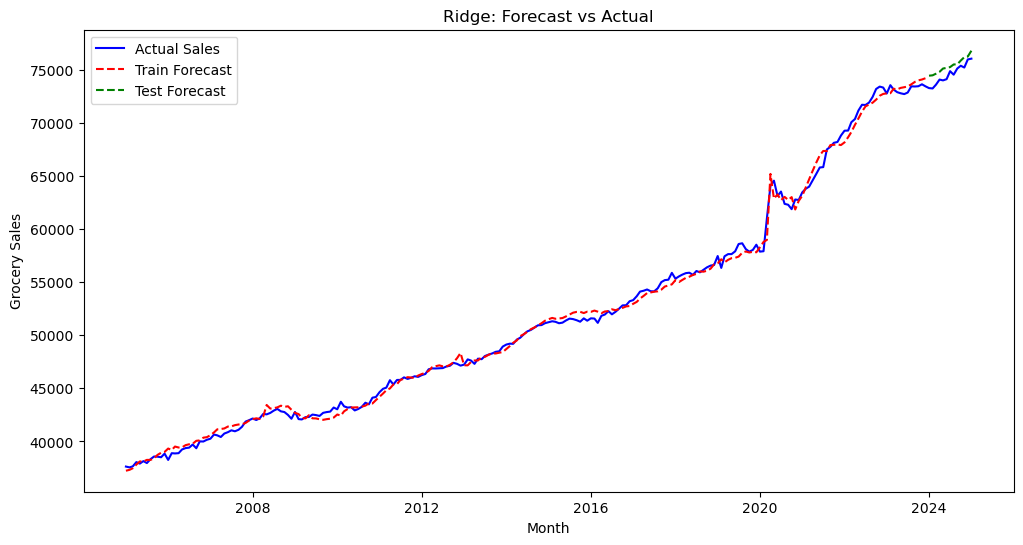

In [15]:
# Plot First-Difference Forecast vs Actual with Confidence Interval Lines
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actual, train, and test forecast
ax.plot(ridge_forecast_df.index, ridge_forecast_df['Actual_Sales'], label="Actual Sales", color="blue")
ax.plot(ridge_forecast_df.index, ridge_forecast_df['Train_Forecast'], label="Train Forecast", color="red", linestyle="dashed")
ax.plot(ridge_forecast_df.index, ridge_forecast_df['Test_Forecast'], label="Test Forecast", color="green", linestyle="dashed")

# Formatting
ax.set_xlabel("Month")
ax.set_ylabel("Grocery Sales")
ax.set_title("Ridge: Forecast vs Actual")
ax.legend()

plt.show()

In [16]:
df.index

DatetimeIndex(['2005-01-01', '2005-02-01', '2005-03-01', '2005-04-01',
               '2005-05-01', '2005-06-01', '2005-07-01', '2005-08-01',
               '2005-09-01', '2005-10-01',
               ...
               '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01',
               '2024-08-01', '2024-09-01', '2024-10-01', '2024-11-01',
               '2024-12-01', '2025-01-01'],
              dtype='datetime64[ns]', name='date', length=241, freq=None)

### OLS ###

In [17]:
from sklearn.linear_model import LinearRegression

# Define training data (2004-2023) and test data (2024)
# X_train = X_scaled_df.loc[:'2023-12-31']  # Features for 2004-2023
# y_train = y.loc[:'2023-12-31']            # Target for 2004-2023

# X_test = X_scaled_df.loc['2024-01-31':]   # Features for 2024
# y_test = y.loc['2024-01-31':]             # Target for 2024

# Train standard linear regression model
lin_reg = LinearRegression().fit(X_train, y_train)

# Predict for training period (2004-2023) and convert to Pandas Series
ols_train_forecast = pd.Series(lin_reg.predict(X_train), index=y_train.index, name="OLS_Train_Forecast")

# Predict for test period (2024) and convert to Pandas Series
ols_test_forecast = pd.Series(lin_reg.predict(X_test), index=y_test.index, name="OLS_Test_Forecast")

In [18]:
# Generate Ridge forecast DataFrame with metrics
ols_forecast_df, ols_metrics = create_forecast_results_df(
    y_train = y_train,
    y_test = y_test,
    train_forecast=ols_train_forecast,
    test_forecast=ols_test_forecast
)

# Print first few rows of the forecast results
print(ols_forecast_df.tail(12))

# Print Ridge Regression performance metrics
print("📊 OLS Regression Performance Metrics:")
for key, value in ols_metrics.items():
    print(f"{key}: {value:.4f}")

            Actual_Sales  Train_Forecast  Test_Forecast  Train_Residuals  \
date                                                                       
2024-02-01       73263.0             NaN   74381.152270              NaN   
2024-03-01       73617.0             NaN   74485.736914              NaN   
2024-04-01       74099.0             NaN   74702.417510              NaN   
2024-05-01       74024.0             NaN   75053.810573              NaN   
2024-06-01       74138.0             NaN   75082.513935              NaN   
2024-07-01       74892.0             NaN   75163.492907              NaN   
2024-08-01       74559.0             NaN   75532.610585              NaN   
2024-09-01       75140.0             NaN   75462.789197              NaN   
2024-10-01       75403.0             NaN   75872.508478              NaN   
2024-11-01       75235.0             NaN   76170.576597              NaN   
2024-12-01       75998.0             NaN   76176.685209              NaN   
2025-01-01  

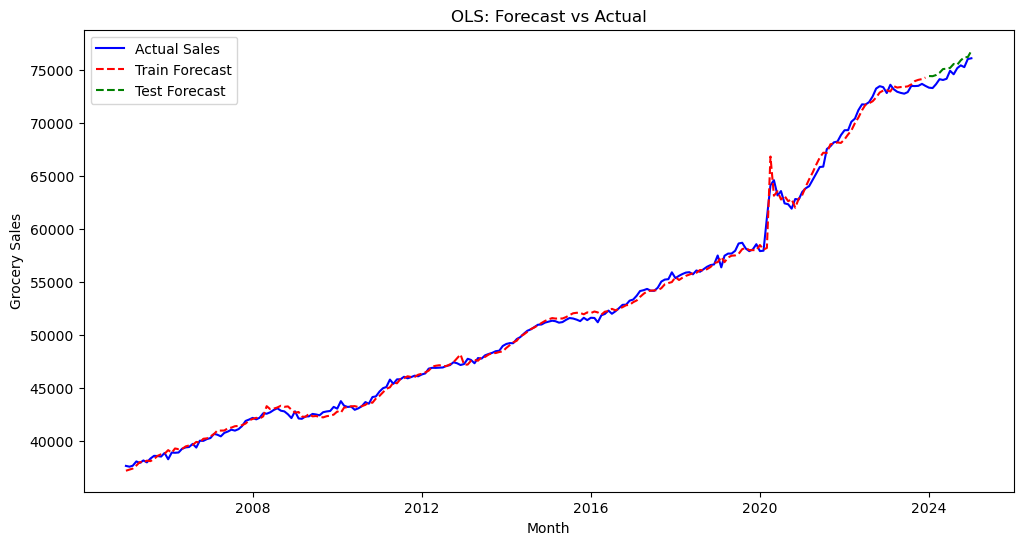

In [19]:
# Plot 
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actual, train, and test forecast
ax.plot(ols_forecast_df.index, ols_forecast_df['Actual_Sales'], label="Actual Sales", color="blue")
ax.plot(ols_forecast_df.index, ols_forecast_df['Train_Forecast'], label="Train Forecast", color="red", linestyle="dashed")
ax.plot(ols_forecast_df.index, ols_forecast_df['Test_Forecast'], label="Test Forecast", color="green", linestyle="dashed")

# Formatting
ax.set_xlabel("Month")
ax.set_ylabel("Grocery Sales")
ax.set_title("OLS: Forecast vs Actual")
ax.legend()

plt.show()

### GRADIENT BOOST ###

In [20]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

target_col = "US Grocery Sales"
from sklearn.linear_model import LinearRegression

# # Define training data (2004-2023) and test data (2024)
# X_train = X_scaled_df.loc[:'2023-12-31']  # Features for 2004-2023
# y_train = y.loc[:'2023-12-31']            # Target for 2004-2023

# X_test = X_scaled_df.loc['2024-01-31':]   # Features for 2024
# y_test = y.loc['2024-01-31':]             # Target for 2024

# Train XG Boost
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.5,
    max_depth=3,
    reg_alpha = 1,
    reg_lambda = 1,
    random_state=42
)

xgb_model.fit(X_train, y_train)

# Predict for training period (2004-2023)
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)

In [21]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Convert NumPy arrays to pandas Series with correct index
y_train_pred_xgb = pd.Series(y_train_pred_xgb, index=y_train.index)
y_test_pred_xgb = pd.Series(y_test_pred_xgb, index=y_test.index)

xgb_forecast_df, xgb_metrics = create_forecast_results_df(
    y_train = y_train,
    y_test = y_test,
    train_forecast = y_train_pred_xgb,
    test_forecast = y_test_pred_xgb
)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

xgb_metrics = {
    "Train R²": r2_score(y_train, y_train_pred_xgb),
    "Test R²": r2_score(y_test, y_test_pred_xgb),
    "Train MSE": mean_squared_error(y_train, y_train_pred_xgb),
    "Test MSE": mean_squared_error(y_test, y_test_pred_xgb),
    "Train MAE": mean_absolute_error(y_train, y_train_pred_xgb),
    "Test MAE": mean_absolute_error(y_test, y_test_pred_xgb),
    "Train MAPE": mape(y_train, y_train_pred_xgb),
    "Test MAPE": mape(y_test, y_test_pred_xgb),
}

xgb_forecast_df

,Actual_Sales,Train_Forecast,Test_Forecast,Train_Residuals,Test_Residuals
date,,,,,
2005-01-01,37628.0,37627.449219,NaN,0.550781,NaN
2005-02-01,37553.0,37555.394531,NaN,-2.394531,NaN
2005-03-01,37645.0,37644.183594,NaN,0.816406,NaN
2005-04-01,38049.0,38049.726562,NaN,-0.726562,NaN
2005-05-01,37908.0,37908.242188,NaN,-0.242188,NaN
...,...,...,...,...,...
2024-09-01,75140.0,NaN,73514.484375,NaN,1625.515625
2024-10-01,75403.0,NaN,73491.921875,NaN,1911.078125
2024-11-01,75235.0,NaN,73500.593750,NaN,1734.406250


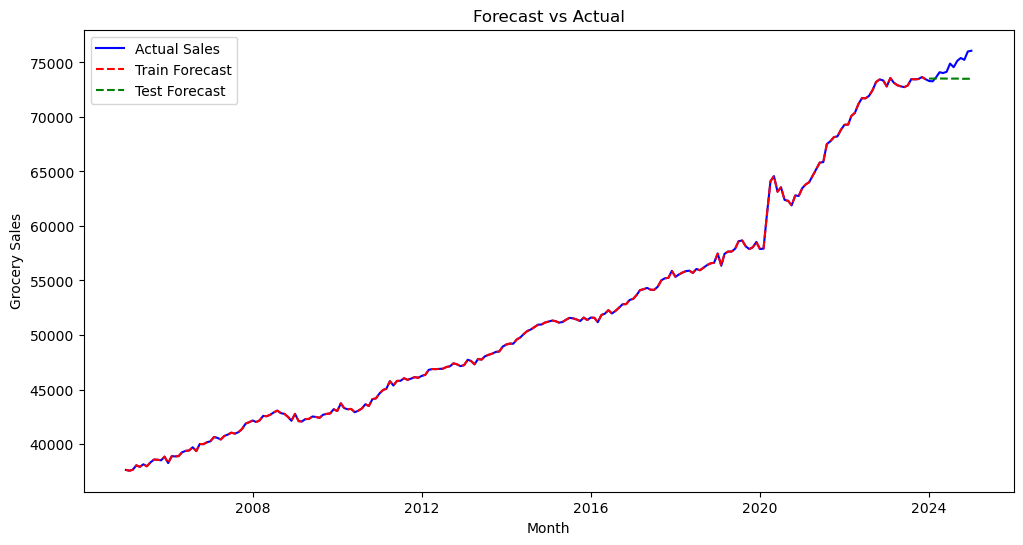

In [22]:
# Plot First-Difference Forecast vs Actual with Confidence Interval Lines
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actual, train, and test forecast
ax.plot(xgb_forecast_df.index, xgb_forecast_df['Actual_Sales'], label="Actual Sales", color="blue")
ax.plot(xgb_forecast_df.index, xgb_forecast_df['Train_Forecast'], label="Train Forecast", color="red", linestyle="dashed")
ax.plot(xgb_forecast_df.index, xgb_forecast_df['Test_Forecast'], label="Test Forecast", color="green", linestyle="dashed")

# Formatting
ax.set_xlabel("Month")
ax.set_ylabel("Grocery Sales")
ax.set_title("Forecast vs Actual")
ax.legend()

plt.show()

In [23]:
# Create a dictionary of model metrics
metrics_data = {
    "Model": ["Ridge", "OLS", "XGBOOST"],
    "Train R²": [ridge_metrics["Train R²"], ols_metrics["Train R²"], xgb_metrics["Train R²"]],
    "Test R²": [ridge_metrics["Test R²"], ols_metrics["Test R²"], xgb_metrics["Test R²"]],
    "Train MSE": [ridge_metrics["Train MSE"], ols_metrics["Train MSE"], xgb_metrics["Train MSE"]],
    "Test MSE": [ridge_metrics["Test MSE"], ols_metrics["Test MSE"], xgb_metrics["Test MSE"]],
    "Train MAE": [ridge_metrics["Train MAE"], ols_metrics["Train MAE"], xgb_metrics["Train MAE"]],
    "Test MAE": [ridge_metrics["Test MAE"], ols_metrics["Test MAE"], xgb_metrics["Test MAE"]],
    "Train MAPE": [ridge_metrics["Train MAPE"], ols_metrics["Train MAPE"], xgb_metrics["Train MAPE"]],
    "Test MAPE": [ridge_metrics["Test MAPE"], ols_metrics["Test MAPE"], xgb_metrics["Test MAPE"]]
}

# Convert to DataFrame
metrics_df = pd.DataFrame(metrics_data)

metrics_df

,Model,Train R²,Test R²,Train MSE,Test MSE,Train MAE,Test MAE,Train MAPE,Test MAPE
0,Ridge,0.997338,0.078395,281609.464917,7.652862e+05,408.402041,814.119617,0.783252,1.095517
1,OLS,0.997662,0.232207,247328.091052,6.375632e+05,350.885573,732.797461,0.663209,0.986091
2,XGBOOST,1.000000,-1.429734,9.589060,2.017612e+06,2.472845,1156.700721,0.004949,1.537594


### CPI FAH FORECAST ###

In [24]:
df_cpi = df[df.index >= '2012-01-01']

In [25]:
# Define dependent variable (Y)
y = df_cpi["CPI (Food at Home)_yoy"]

# Define independent variables (X)
X = df_cpi[["PPI Food and Feed_yoy_lag4", "PPI Final Food_yoy_lag5", "Oil Prices_yoy_lag9", "PPI Grocery_yoy"]]

# Count total missing values per column
missing_counts_y = y.isna().sum()
missing_counts_y = missing_counts_y[missing_counts_y > 0]

# Count total missing values per column
missing_counts_X = X.isna().sum()
missing_counts_X = missing_counts_X[missing_counts_X > 0]

print(missing_counts_y, missing_counts_X) 


[] Series([], dtype: int64)


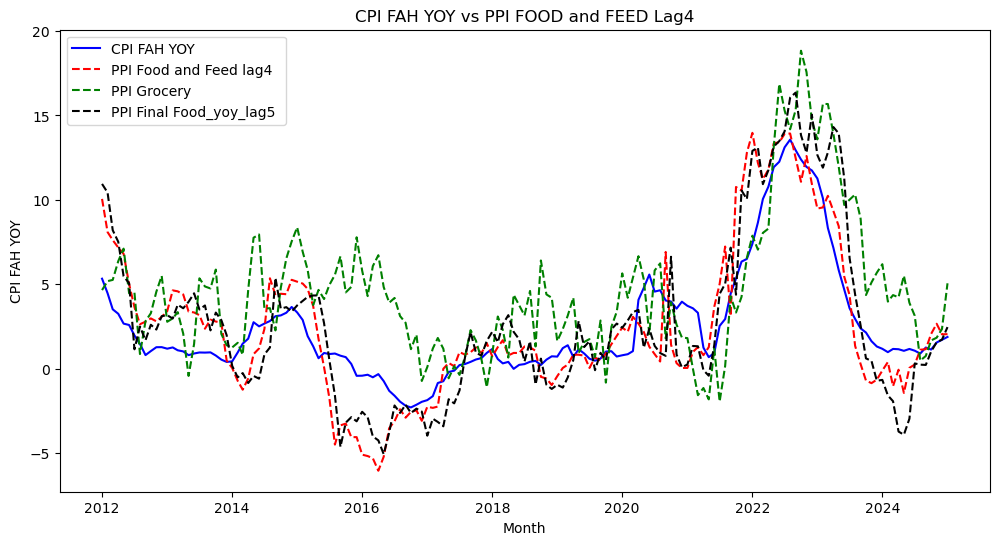

In [26]:
# Plot First-Difference Forecast vs Actual with Confidence Interval Lines
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actual, train, and test forecast
ax.plot(df_cpi.index, df_cpi['CPI (Food at Home)_yoy'], label="CPI FAH YOY", color="blue")
ax.plot(df_cpi.index, df_cpi['PPI Food and Feed_yoy_lag4'], label="PPI Food and Feed lag4", color="red", linestyle="dashed")
ax.plot(df_cpi.index, df_cpi['PPI Grocery_yoy'], label="PPI Grocery", color="green", linestyle="dashed")
ax.plot(df_cpi.index, df_cpi['PPI Final Food_yoy_lag5'], label="PPI Final Food_yoy_lag5 ", color="black", linestyle="dashed")
# Formatting
ax.set_xlabel("Month")
ax.set_ylabel("CPI FAH YOY")
ax.set_title("CPI FAH YOY vs PPI FOOD and FEED Lag4")
ax.legend()

plt.show()

In [27]:
# Add a constant term for the intercept
X = sm.add_constant(X)

# Fit the model
cpi_model = sm.OLS(y, X).fit()

# Display the summary
print(cpi_model.summary())

                              OLS Regression Results                              
Dep. Variable:     CPI (Food at Home)_yoy   R-squared:                       0.840
Model:                                OLS   Adj. R-squared:                  0.836
Method:                     Least Squares   F-statistic:                     199.8
Date:                    Sun, 30 Mar 2025   Prob (F-statistic):           1.92e-59
Time:                            10:11:43   Log-Likelihood:                -269.17
No. Observations:                     157   AIC:                             548.3
Df Residuals:                         152   BIC:                             563.6
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [28]:
from sklearn.linear_model import LinearRegression

# Define dependent variable (Y)
y = df_cpi["CPI (Food at Home)_yoy"]

# Define independent variables (X)
X = df_cpi[["PPI Food and Feed_yoy_lag4", "PPI Final Food_yoy_lag5", "Oil Prices_yoy_lag9", "PPI Grocery_yoy"]]

# Define training data (2004-2023) and test data (2024)
X_train = X.loc[:'2024-08-1']  # Ensures only selected columns are included
y_train = y.loc[:'2024-08-01']  # Target for 2004-2023

X_test = X.loc['2024-09-01':]  # Ensures only selected columns are included
y_test = y.loc['2024-09-01':]  # Target for 2024


In [29]:
print(X_train.isna().sum())  # Count NaNs in training data
print(X_test.isna().sum())   # Count NaNs in test data


PPI Food and Feed_yoy_lag4    0
PPI Final Food_yoy_lag5       0
Oil Prices_yoy_lag9           0
PPI Grocery_yoy               0
dtype: int64
PPI Food and Feed_yoy_lag4    0
PPI Final Food_yoy_lag5       0
Oil Prices_yoy_lag9           0
PPI Grocery_yoy               0
dtype: int64


In [30]:
# Train standard linear regression model
lin_reg = LinearRegression().fit(X_train, y_train)

# Predict for training period (2004-2023) and convert to Pandas Series
cpi_train_fcst = pd.Series(lin_reg.predict(X_train), index=y_train.index, name="CPI_Train_Forecast")

# Predict for test period (2024) and convert to Pandas Series
cpi_test_fcst = pd.Series(lin_reg.predict(X_test), index=y_test.index, name="CPI_Test_Forecast")

In [31]:
# Generate forecast DataFrame with metrics
cpi_forecast_df, cpi_metrics = create_forecast_results_df(
    y_train = y_train,
    y_test = y_test,
    train_forecast=cpi_train_fcst,
    test_forecast=cpi_test_fcst
)

# Print first few rows of the forecast results
print(cpi_forecast_df.tail(12))

# Print Ridge Regression performance metrics
print("📊 OLS Regression Performance Metrics:")
for key, value in cpi_metrics.items():
    print(f"{key}: {value:.2f}")

            Actual_Sales  Train_Forecast  Test_Forecast  Train_Residuals  \
date                                                                       
2024-02-01      0.983797        0.962010            NaN         0.021787   
2024-03-01      1.174533        0.522254            NaN         0.652279   
2024-04-01      1.157035        0.578359            NaN         0.578676   
2024-05-01      1.062992        0.425821            NaN         0.637170   
2024-06-01      1.173390        0.579268            NaN         0.594122   
2024-07-01      1.069835        0.864953            NaN         0.204882   
2024-08-01      0.900476        0.381390            NaN         0.519087   
2024-09-01      1.258809             NaN       0.470127              NaN   
2024-10-01      1.136562             NaN       1.177333              NaN   
2024-11-01      1.554147             NaN       1.509460              NaN   
2024-12-01      1.719773             NaN       1.444816              NaN   
2025-01-01  

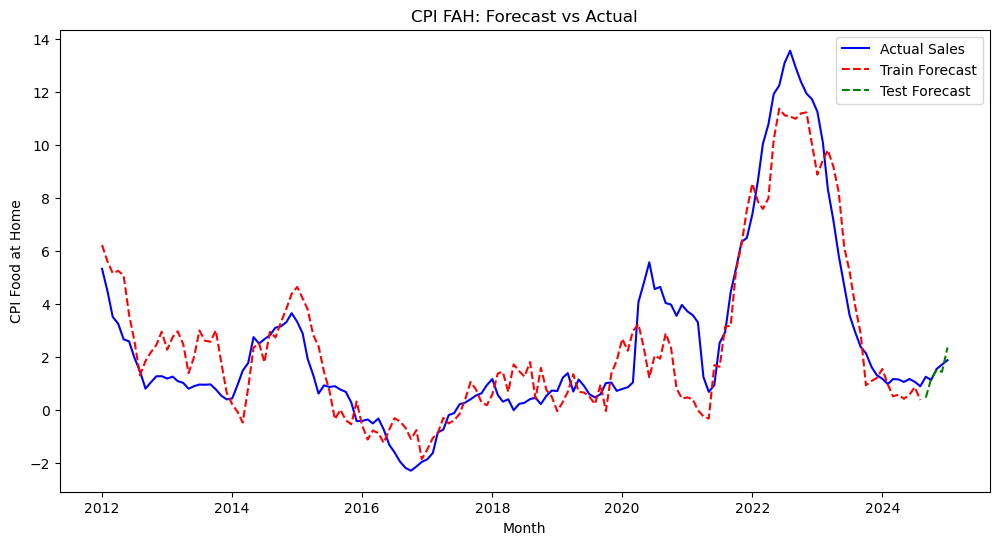

In [32]:
# Plot First-Difference Forecast vs Actual with Confidence Interval Lines
fig, ax = plt.subplots(figsize=(12, 6))

# Plot actual, train, and test forecast
ax.plot(cpi_forecast_df.index, cpi_forecast_df['Actual_Sales'], label="Actual Sales", color="blue")
ax.plot(cpi_forecast_df.index, cpi_forecast_df['Train_Forecast'], label="Train Forecast", color="red", linestyle="dashed")
ax.plot(cpi_forecast_df.index, cpi_forecast_df['Test_Forecast'], label="Test Forecast", color="green", linestyle="dashed")

# Formatting
ax.set_xlabel("Month")
ax.set_ylabel("CPI Food at Home")
ax.set_title("CPI FAH: Forecast vs Actual")
ax.legend()

plt.show()


In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# Make sure the index is datetime and sorted
df_cpi = df_cpi.sort_index()
df_cpi.index = pd.to_datetime(df_cpi.index)  # If it's not already datetime

results = []

# Define unique months in the index
all_months = df_cpi.index.to_period('M').unique()  # PeriodIndex for monthly grouping

# Define rolling parameters
n_periods = 24  # last 24 months
test_window = 5

for i in range(len(all_months) - n_periods, len(all_months) - test_window + 1):
    test_months = all_months[i:i + test_window]
    train_months = all_months[:i]  # everything before the test window
    
    # Filter data by index (monthly PeriodIndex)
    train_df = df_cpi[df_cpi.index.to_period('M').isin(train_months)]
    test_df = df_cpi[df_cpi.index.to_period('M').isin(test_months)]
    
    # Fit your model (replace with your actual model and features)
    model = LinearRegression()
    X_train = train_df[["PPI Food and Feed_yoy_lag4", "PPI Final Food_yoy_lag5", "Oil Prices_yoy_lag9", "PPI Grocery_yoy"]]
    y_train = train_df["CPI (Food at Home)_yoy"]
    X_test = test_df[["PPI Food and Feed_yoy_lag4", "PPI Final Food_yoy_lag5", "Oil Prices_yoy_lag9", "PPI Grocery_yoy"]]
    y_test = test_df["CPI (Food at Home)_yoy"]
    
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)
    
    # Store performance
    mae = mean_absolute_error(y_test, forecast)
    
    results.append({
        'test_start': test_months[0].strftime('%Y-%m'),
        'test_end': test_months[-1].strftime('%Y-%m'),
        'MAE': mae,
        'Actual': y_test.values,
        'Forecast': forecast
    })

# Turn results into a DataFrame
rolling_results_df = pd.DataFrame(results)


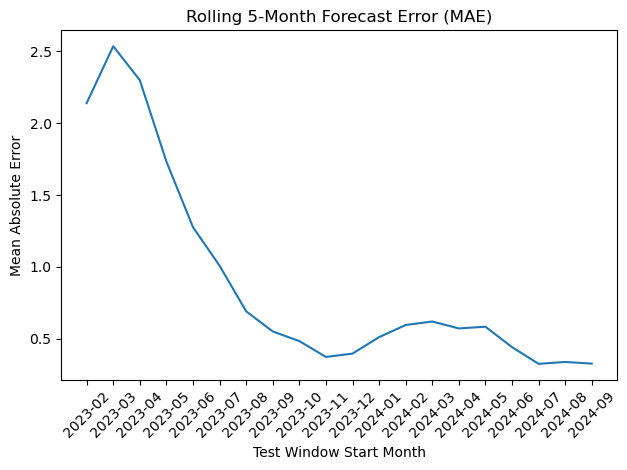

In [34]:
plt.plot(rolling_results_df['test_start'], rolling_results_df['MAE'])
plt.xticks(rotation=45)
plt.title('Rolling 5-Month Forecast Error (MAE)')
plt.xlabel('Test Window Start Month')
plt.ylabel('Mean Absolute Error')
plt.tight_layout()
plt.show()

In [417]:
#MERGE The three forecast dfs with the main dfs

# Remove Actual Sales from each df or we will get a duplication error
for forecast_df in [ridge_forecast_df, ols_forecast_df, xgb_forecast_df, cpi_forecast_df]:
    forecast_df.drop(columns="Actual_Sales", inplace=True)

#Rename columns
ridge_forecast_df = ridge_forecast_df.rename(columns={
    "Train_Forecast": "Ridge_Train_Forecast",
    "Test_Forecast": "Ridge_Test_Forecast",
    "Train_Residuals": "Ridge_Train_Residuals",
    "Test_Residuals": "Ridge_Test_Residuals"
})

ols_forecast_df = ols_forecast_df.rename(columns={
    "Train_Forecast": "OLS_Train_Forecast",
    "Test_Forecast": "OLS_Test_Forecast",
    "Train_Residuals": "OLS_Train_Residuals",
    "Test_Residuals": "OLS_Test_Residuals"
})

xgb_forecast_df = xgb_forecast_df.rename(columns={
    "Train_Forecast": "XGB_Train_Forecast",
    "Test_Forecast": "XGB_Test_Forecast",
    "Train_Residuals": "XGB_Train_Residuals",
    "Test_Residuals": "XGB_Test_Residuals"
})

cpi_forecast_df = cpi_forecast_df.rename(columns={
        "Train_Forecast": "CPI_Train_Forecast",
        "Test_Forecast": "CPI_Test_Forecast",
        "Train_Residuals": "CPI_Train_Residuals",
        "Test_Residuals": "CPI_Test_Residuals"
})

df = df.merge(ridge_forecast_df, how="left", left_index=True, right_index=True)
df = df.merge(ols_forecast_df, how="left", left_index=True, right_index=True)
df = df.merge(xgb_forecast_df, how="left", left_index=True, right_index=True)
df = df.merge(cpi_forecast_df, how="left", left_index=True, right_index=True)

df

,US Grocery Sales,CPI (Food at Home),Real Disposable Income,Unemployment Rate,Initial Jobless Claims,Continued Jobless Claims,GDP,Personal Savings,Consumer Debt % DI,Credit Card Delinquency,...,OLS_Train_Residuals,OLS_Test_Residuals,XGB_Train_Forecast,XGB_Test_Forecast,XGB_Train_Residuals,XGB_Test_Residuals,CPI_Train_Forecast,CPI_Test_Forecast,CPI_Train_Residuals,CPI_Test_Residuals
date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,37628.0,188.100,11226.5,5.3,1717000.0,13619000.0,15844.727,247.1,7.303833,3.70,...,454.952283,NaN,37627.449219,NaN,0.550781,NaN,NaN,NaN,NaN,NaN
2005-02-01,37553.0,187.700,11229.0,5.4,1247000.0,10746000.0,15844.727,210.6,7.303833,3.70,...,269.421314,NaN,37555.394531,NaN,-2.394531,NaN,NaN,NaN,NaN,NaN
2005-03-01,37645.0,188.100,11268.8,5.2,1328000.0,10638000.0,15844.727,230.2,7.303833,3.70,...,267.415241,NaN,37644.183594,NaN,0.816406,NaN,NaN,NaN,NaN,NaN
2005-04-01,38049.0,190.000,11304.2,5.2,1616000.0,13022000.0,15922.782,195.4,7.239296,3.67,...,385.823453,NaN,38049.726562,NaN,-0.726562,NaN,NaN,NaN,NaN,NaN
2005-05-01,37908.0,190.200,11352.7,5.1,1308000.0,10345000.0,15922.782,243.6,7.239296,3.67,...,-79.238493,NaN,37908.242188,NaN,-0.242188,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01,75140.0,307.201,17519.6,4.1,897000.0,7325000.0,23400.294,830.7,5.478743,3.20,...,NaN,-322.789197,NaN,73514.484375,NaN,1625.515625,NaN,0.470127,NaN,0.788682
2024-10-01,75403.0,307.798,17584.7,4.1,948000.0,7494000.0,23536.293,881.0,5.512139,3.08,...,NaN,-469.508478,NaN,73491.921875,NaN,1911.078125,NaN,1.177333,NaN,-0.040771
2024-11-01,75235.0,308.881,17618.8,4.2,1095000.0,9417000.0,NaN,838.1,NaN,NaN,...,NaN,-935.576597,NaN,73500.593750,NaN,1734.406250,NaN,1.509460,NaN,0.044687


In [418]:
df.to_csv('forecast_df.csv')
metrics_df.to_csv('model_performance_metrics.csv')